# Imports

In [ ]:
from mnist_utils import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Lambda,Flatten,MaxPooling2D,Dropout,Conv2D 



In [ ]:
exec(open('mnist_utils.py').read())


# I- Contrastive loss for MNIST



In [ ]:
train_images,train_labels,test_images,test_labels = load_MNIST_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
### all_train[i] contains all train images of class i
all_train, all_test = data_groupby_class(train_images,train_labels,test_images,test_labels)

In [ ]:
# shape = (nb_samples,sample_size)
all_train[9].shape

(5949, 784)

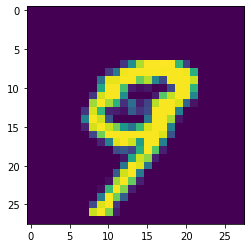

In [ ]:
plt.imshow(all_train[9][10,].reshape(28,28))

    
# 1- Prepare train sets

###Prepare pairs of examples for training, keep only classes 0 to 4 

In [ ]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same,labels_same = prepare_same_pairs(all_train,n_pairs_same,'train')
pairs_diff,labels_diff = prepare_different_pairs(all_train,n_pairs_diff,'train')

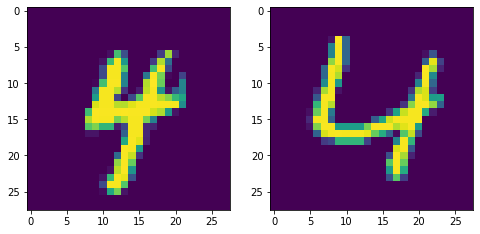

In [ ]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(pairs_same[20,:,0].reshape(28,28))
fig.add_subplot(1,2,2)
plt.imshow(pairs_same[20,:,1].reshape(28,28))

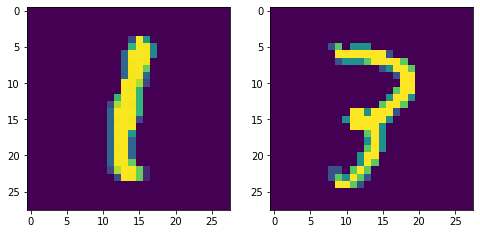

In [ ]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(pairs_diff[20,:,0].reshape(28,28))
fig.add_subplot(1,2,2)
plt.imshow(pairs_diff[20,:,1].reshape(28,28))

create y such as equals 1 if pairs are from the same class, 0 otherwise :

In [ ]:
y = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x = np.concatenate([pairs_same, pairs_diff], axis = 0)

In [ ]:
x_train, y_train = shuffle(x, y, random_state=0)

In [ ]:
x_train.shape,y_train.shape

((3000, 784, 2), (3000,))

###Prepare pairs of examples for training, keep classes 0 to 4 and one sample for classes 5 to 9

In [ ]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same,labels_same = prepare_same_pairs2(all_train,n_pairs_same,'train')
pairs_diff,labels_diff = prepare_different_pairs2(all_train,n_pairs_diff,'test')

y2 = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x2 = np.concatenate([pairs_same, pairs_diff], axis = 0)

x_train2, y_train2 = shuffle(x2, y2, random_state=0)

In order to have the correct shape for the CNN siamese model we need to reshape our data

In [ ]:
shape = x_train.shape
x_train = x_train.reshape((shape[0],28,28,1,shape[2]))
shape = x_train2.shape
x_train2 = x_train2.reshape((shape[0],28,28,1,shape[2]))

    
# 2- Prepare test sets

### Create easy test set with only classes 0-4

In [ ]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same_test,labels_same_test = prepare_same_pairs_test(all_test,n_pairs_same,'easy')
pairs_diff_test,labels_diff_test = prepare_different_pairs_test(all_test,n_pairs_diff,'easy')

y_test_easy = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x_test_easy = np.concatenate([pairs_same_test, pairs_diff_test], axis = 0)

x_test_easy, y_test_easy = shuffle(x_test_easy, y_test_easy, random_state=0)

### Create medium test set with all classes

In [ ]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same_test,labels_same_test = prepare_same_pairs(all_test,n_pairs_same,'test')
pairs_diff_test,labels_diff_test = prepare_different_pairs(all_test,n_pairs_diff,'test')

y_test = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x_test = np.concatenate([pairs_same_test, pairs_diff_test], axis = 0)

x_test, y_test = shuffle(x_test, y_test, random_state=0)

### Create hard test set with only classes 5-9

In [ ]:
n_pairs_same = 1000
n_pairs_diff = 2000
pairs_same_test,labels_same_test = prepare_same_pairs_test(all_test,n_pairs_same,'hard')
pairs_diff_test,labels_diff_test = prepare_different_pairs_test(all_test,n_pairs_diff,'hard')

y_test_hard = np.array([1.]*n_pairs_same + [0.]*n_pairs_diff)
x_test_hard = np.concatenate([pairs_same_test, pairs_diff_test], axis = 0)

x_test_hard, y_test_hard = shuffle(x_test_hard, y_test_hard, random_state=0)

# 3- Build the first CNN model without 5 to 9 classes


In [ ]:
#prepare data for fitting the transfered model
xtr = train_images.reshape(train_images.shape[0],28,28,1)
ytr = train_labels
xte = test_images.reshape(test_images.shape[0],28,28,1)
yte = test_labels

In [ ]:
x_train_flat = xtr.copy().reshape(-1,784)
x_test_flat = xte.copy().reshape(-1,784)

Let's apply a t-SNE transformation on the train and test set 

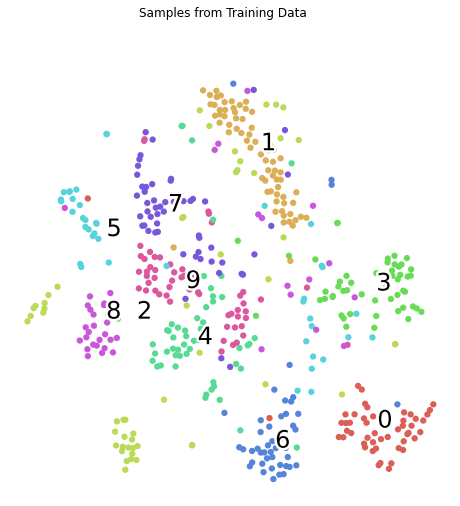

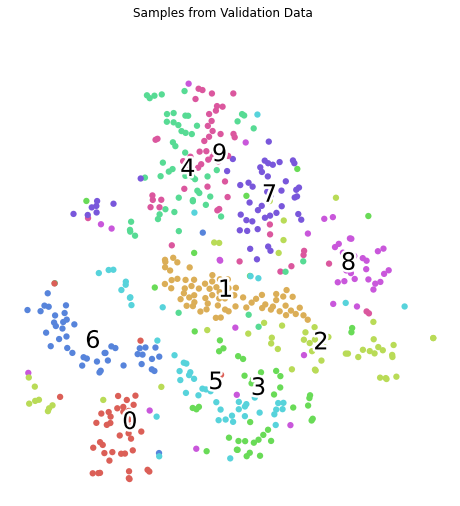

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, ytr[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, yte[:512], "Samples from Validation Data")

Let's try some Transfer_learning first

In [ ]:
### train a cnn classification model on xt, yt and after that use its weights 
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping
yte = keras.utils.to_categorical(test_labels, 10) 
ytr = keras.utils.to_categorical(train_labels, 10) 
def define_model(input_shape):
  input = Input(shape=input_shape)
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  model.add(layers.Activation(activations.softmax))
  # compile model
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

tmodel = define_model(xtr.shape[1:])
	# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

tmodel.fit(xtr, ytr, epochs=10, batch_size=256,verbose=1,validation_data=(xte,yte),callbacks = [es])
	# save model
tmodel.save('classification_model.h5')

Epoch 1/10
235/235 [==============================] - 3s 15ms/step - loss: 0.2742 - accuracy: 0.9166 - val_loss: 0.0538 - val_accuracy: 0.9825
Epoch 2/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0853 - accuracy: 0.9747 - val_loss: 0.0451 - val_accuracy: 0.9845
Epoch 3/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0649 - accuracy: 0.9811 - val_loss: 0.0355 - val_accuracy: 0.9882
Epoch 4/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0512 - accuracy: 0.9849 - val_loss: 0.0324 - val_accuracy: 0.9886
Epoch 5/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0469 - accuracy: 0.9862 - val_loss: 0.0358 - val_accuracy: 0.9895
Epoch 00005: early stopping


Okey, that's a great model for MNIST classification using only classes 0 to 4, let's use It as a base model for next models for one shot learning

### 3-1-Prepare the data

In [ ]:
tmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
#remove last layer for classification (activation softmax) and replace it with another layer giving the encodings of the images
tmodel_modified = Sequential()
for layer in tmodel.layers[:-1]: # go through until last layer
    tmodel_modified.add(layer)
tmodel_modified.add(layers.Activation(activations.relu))
tmodel_modified.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

### 3-2 Build and train the model

In [ ]:
from keras.callbacks import EarlyStopping
### hyperparameters of the model
nb_epochs = 20
batch_size = 35

### model
input_shape = x_train.shape[1:4]

base_network_contrastive = tf.keras.models.clone_model(tmodel_modified)
base_network_contrastive.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_contrastive(branch1)
processed2 = base_network_contrastive(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='adam')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit([x_train[:,:,:,:, 0], x_train[:,:,:,:, 1]], y_train,validation_split=0.2, batch_size=batch_size, epochs=nb_epochs,callbacks=[es])

pred_train = model.predict([x_train[:,:,:,:,0], x_train[:,:,:,:,1]])
acc = compute_accuracy(pred_train, y_train,0.5)
print('train accuracy of our model = ',acc)

Epoch 1/20
69/69 [==============================] - 1s 9ms/step - loss: 1.4894 - val_loss: 0.0703
Epoch 2/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0991 - val_loss: 0.0443
Epoch 3/20
69/69 [==============================] - 0s 5ms/step - loss: 0.0733 - val_loss: 0.0364
Epoch 4/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0596 - val_loss: 0.0327
Epoch 5/20
69/69 [==============================] - 0s 5ms/step - loss: 0.0517 - val_loss: 0.0282
Epoch 6/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.0236
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0398 - val_loss: 0.0227
Epoch 8/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 0.0200
Epoch 9/20
69/69 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0194
Epoch 10/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0303 - val_loss: 0.0178
Epoch 11/20
69/69 [

accuracy on easy test set 

In [ ]:
test_shape= x_test_easy.shape
x_test_easy = x_test_easy.reshape(test_shape[0],28,28,1,test_shape[2])

pred_test_easy = model.predict([x_test_easy[:,:,:,:,0], x_test_easy[:,:,:,:,1]])
acc_test_easy = compute_accuracy(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test_easy)

Test accuracy of our model =  0.99


accuracy on hard test set

In [ ]:
test_shape= x_test_hard.shape
x_test_hard = x_test_hard.reshape(test_shape[0],28,28,1,test_shape[2])

pred_test_hard = model.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.677


accuracy on medium test set

In [ ]:
test_shape= x_test.shape
x_test = x_test.reshape(test_shape[0],28,28,1,test_shape[2])

pred_test = model.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.8896666666666667


### 3-3 Impact of the threshhold value on accuracy 

train and easy data set

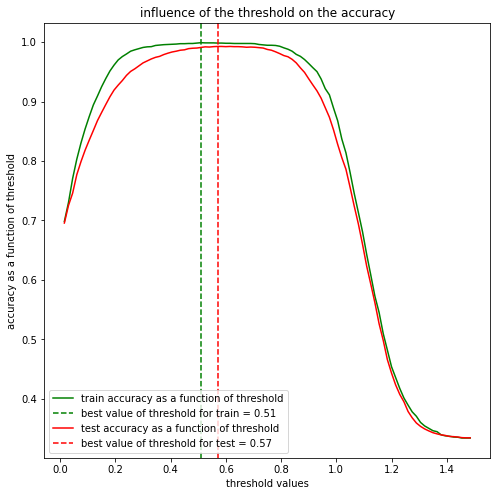

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_easy, y_test_easy,pred_train, y_train)

In [ ]:
acc_train = compute_accuracy(pred_train, y_train,best_train_threshold)
acc_test_easy = compute_accuracy(pred_test_easy, y_test_easy,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test_easy)
print('best threshold for test is ',best_test_threshold)

train accuracy of our best first model =  0.998
test accuracy of our best first model =  0.997
best threshold for test is  0.525


train and hard data set

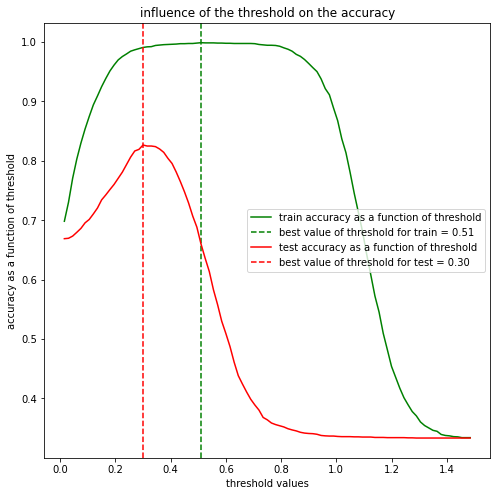

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_hard, y_test_hard,pred_train, y_train)

In [ ]:
acc_train = compute_accuracy(pred_train, y_train,best_train_threshold)
acc_test_hard = compute_accuracy(pred_test_hard, y_test_hard,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test_hard)
print('best threshold for test is ',best_test_threshold)

train accuracy of our best first model =  0.997
test accuracy of our best first model =  0.816
best threshold for test is  0.315


train and medium data set

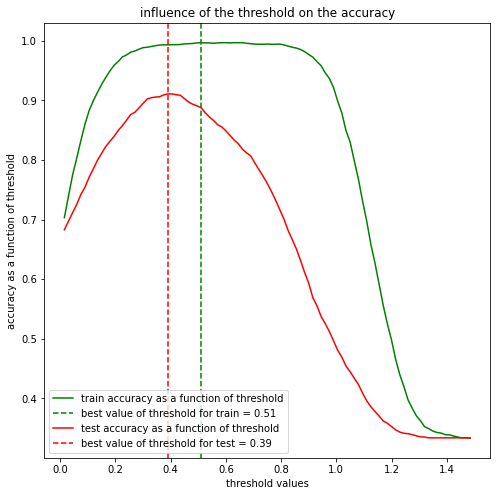

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train)

In [ ]:
acc_train = compute_accuracy(pred_train, y_train,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold for test is ',best_test_threshold)

train accuracy of our best first model =  0.997
test accuracy of our best first model =  0.911
best threshold for test is  0.39


### Check the encodings of test images

In [ ]:
encodings = base_network_contrastive.predict(test_images.reshape(test_images.shape[0],28,28,1)) 
pca , transformed_encodings = fitting_pca(encodings,nb_components = 2)
pca.explained_variance_ratio_.sum() * 100

45.28735280036926

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



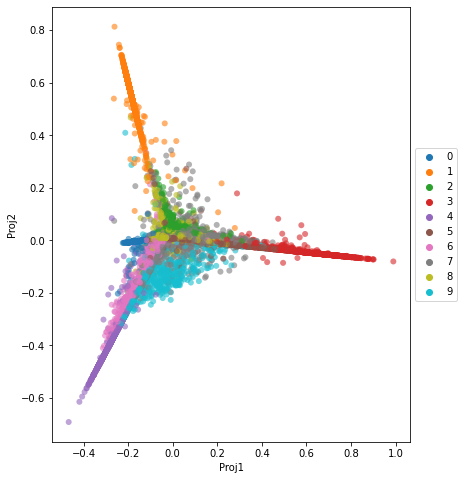

In [ ]:
transformed_encodings_plot_2d(transformed_encodings,test_labels)

In [ ]:
pca , transformed_encodings = fitting_pca(encodings,nb_components = 3)

transformed_encodings_plot_3d(pca,transformed_encodings[:5000],test_labels[:5000])

# 4- Build the second CNN for contrastive loss with classes 5 to 9

### 4-1 Build the model, train and test

In [ ]:
### hyperparameters of the model
nb_epochs = 20
batch_size = 35

### model
input_shape = x_train2.shape[1:4]

base_network_contrastive2 = tf.keras.models.clone_model(tmodel_modified)
base_network_contrastive2.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_contrastive2(branch1)
processed2 = base_network_contrastive2(branch2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed1, processed2])

model = Model([branch1, branch2], distance)

model.compile(loss=contrastive_loss, optimizer='adam')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history2 = model.fit([x_train2[:,:,:,:, 0], x_train2[:,:,:,:, 1]], y_train2, batch_size=batch_size, epochs=nb_epochs, validation_split = 0.2, callbacks = [es])

pred_train = model.predict([x_train2[:,:,:,:,0], x_train2[:,:,:,:,1]])
acc = compute_accuracy(pred_train, y_train2,0.5)
print('train accuracy of our model = ',acc)

Epoch 1/20
69/69 [==============================] - 1s 8ms/step - loss: 1.5321 - val_loss: 0.0903
Epoch 2/20
69/69 [==============================] - 0s 5ms/step - loss: 0.1078 - val_loss: 0.0616
Epoch 3/20
69/69 [==============================] - 0s 5ms/step - loss: 0.0926 - val_loss: 0.0475
Epoch 4/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0668 - val_loss: 0.0386
Epoch 5/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0564 - val_loss: 0.0327
Epoch 6/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0514 - val_loss: 0.0288
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.0269
Epoch 8/20
69/69 [==============================] - 0s 5ms/step - loss: 0.0397 - val_loss: 0.0279
Epoch 00008: early stopping
train accuracy of our model =  0.9946666666666667


accuracy on easy test set

In [ ]:
pred_test_easy = model.predict([x_test_easy[:,:,:,:,0], x_test_easy[:,:,:,:,1]])
acc_test_easy = compute_accuracy(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.911


accuracy on hard test set

In [ ]:
pred_test_hard = model.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.83


accuracy on medium test set

In [ ]:
pred_test = model.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.9136666666666666


### 4-2- Impact of the threshold value on the accuracy

train and easy set

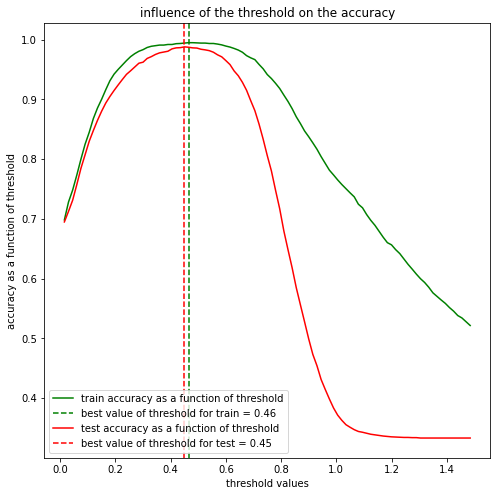

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_easy, y_test_easy,pred_train, y_train2)

train and hard set

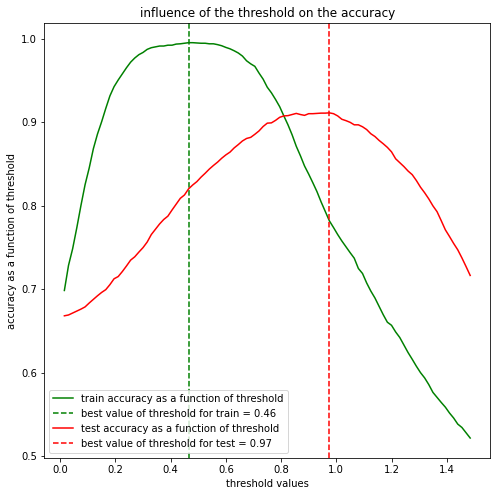

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test_hard, y_test_hard,pred_train, y_train2)

train and medium set

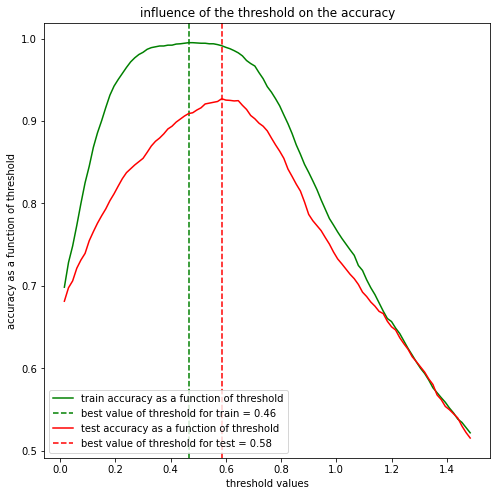

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot(pred_test, y_test,pred_train, y_train2)

In [ ]:
acc_train = compute_accuracy(pred_train, y_train2,best_train_threshold)
acc_test = compute_accuracy(pred_test, y_test,best_test_threshold)
print('train accuracy of our best first model = ',acc_train)
print('test accuracy of our best first model = ',acc_test)
print('best threshold is ',best_test_threshold)

train accuracy of our best first model =  0.995
test accuracy of our best first model =  0.927
best threshold is  0.585


### Checking the encodings

In [ ]:
encodings = base_network_contrastive2.predict(test_images.reshape(test_images.shape[0],28,28,1)) 
pca , transformed_encodings = fitting_pca(encodings,nb_components = 2)
pca.explained_variance_ratio_.sum() * 100

38.47329616546631

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



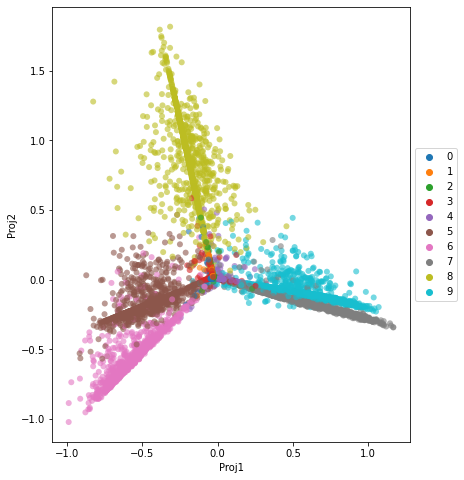

In [ ]:
transformed_encodings_plot_2d(transformed_encodings,test_labels)

# II- Binary cross entropy for one shot learning

### II-1 test without classes 5 to 9

In [54]:
from tensorflow.keras.layers import BatchNormalization

### hyperparameters of the model
nb_epochs = 50
batch_size = 256

### model
input_shape = x_train.shape[1:4]
base_network_binary = tf.keras.models.clone_model(tmodel_modified)
base_network_binary.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_binary(branch1)
processed2 = base_network_binary(branch2)

###### what differs from contrastive loss setting, we add a fully connected layer and we use binary crossentropy
L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance, output_shape=lambda x: x[0])([processed1, processed2])
BN = BatchNormalization()(distance)
prediction = Dense(1,activation='sigmoid')(BN)
siamese_net = Model([branch1,branch2],prediction)


siamese_net.compile(loss='binary_crossentropy', optimizer='adam')
history_3 =siamese_net.fit([x_train[:,:,:,:, 0], x_train[:,:,:,:, 1]], y_train, batch_size=batch_size,validation_split=0.2, epochs=nb_epochs, callbacks = [es])

pred_train = siamese_net.predict([x_train[:,:,:,:,0], x_train[:,:,:,:,1]])


Epoch 1/50
10/10 [==============================] - 0s 38ms/step - loss: 0.6557 - val_loss: 0.5131
Epoch 2/50
10/10 [==============================] - 0s 22ms/step - loss: 0.6151 - val_loss: 0.4511
Epoch 3/50
10/10 [==============================] - 0s 22ms/step - loss: 0.5701 - val_loss: 0.3979
Epoch 4/50
10/10 [==============================] - 0s 23ms/step - loss: 0.5285 - val_loss: 0.3485
Epoch 5/50
10/10 [==============================] - 0s 23ms/step - loss: 0.5036 - val_loss: 0.3327
Epoch 6/50
10/10 [==============================] - 0s 22ms/step - loss: 0.4808 - val_loss: 0.3241
Epoch 7/50
10/10 [==============================] - 0s 22ms/step - loss: 0.4606 - val_loss: 0.3148
Epoch 8/50
10/10 [==============================] - 0s 22ms/step - loss: 0.4406 - val_loss: 0.3073
Epoch 9/50
10/10 [==============================] - 0s 22ms/step - loss: 0.4172 - val_loss: 0.2915
Epoch 10/50
10/10 [==============================] - 0s 22ms/step - loss: 0.3872 - val_loss: 0.2809
Epoch 11/

train accuracy

In [ ]:
acc = compute_accuracy2(pred_train, y_train,0.5)
print('train accuracy of our model = ',acc)

train accuracy of our model =  0.988


accuracy on easy test set

In [ ]:
pred_test_easy = siamese_net.predict([x_test_easy[:,:,:,:,0], x_test_easy[:,:,:,:,1]])
acc_test_easy = compute_accuracy2(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test_easy)

Test accuracy of our model =  0.9843333333333333


accuracy on hard test set

In [ ]:
pred_test_hard = siamese_net.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy2(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.6863333333333334


accuracy on medium test set


In [ ]:
pred_test = siamese_net.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy2(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.8133333333333334


### Influence of threshold

train and easy set

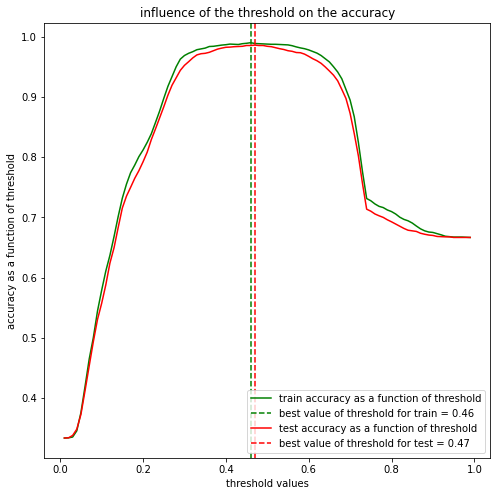

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_easy, y_test_easy,pred_train, y_train)

train and hard set

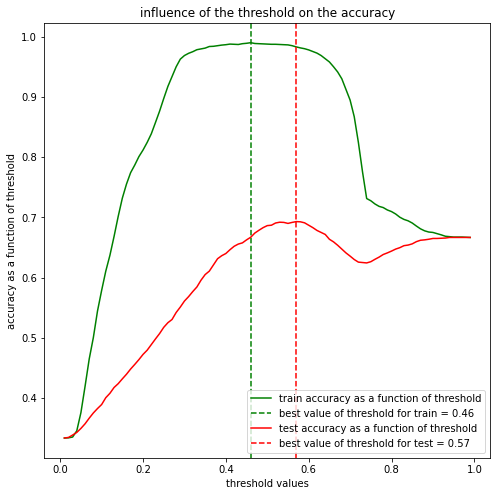

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_hard, y_test_hard,pred_train, y_train)

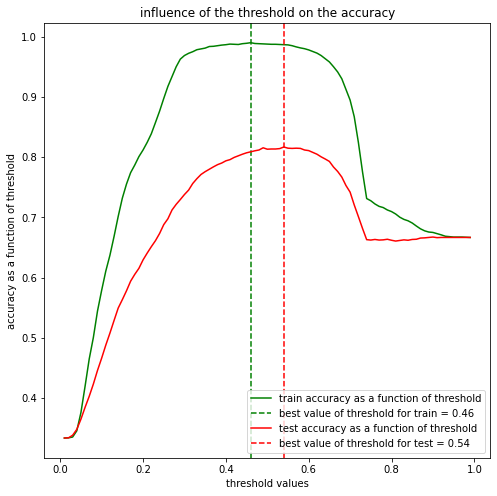

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test,y_test,pred_train, y_train)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



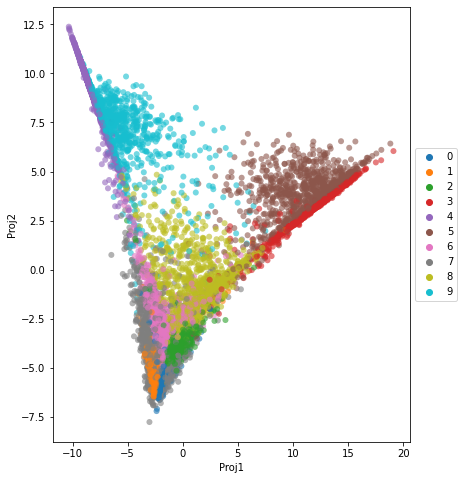

In [ ]:
encodings = base_network_binary.predict(test_images.reshape(test_images.shape[0],28,28,1)) 
pca , transformed_encodings = fitting_pca(encodings,nb_components = 2)
pca.explained_variance_ratio_.sum() * 100
transformed_encodings_plot_2d(transformed_encodings,test_labels)

### II-2 test with classes 5 to 9

In [55]:
from tensorflow.keras.layers import BatchNormalization

### hyperparameters of the model
nb_epochs = 50
batch_size = 256

### model
input_shape = x_train2.shape[1:4]
base_network_binary2 = tf.keras.models.clone_model(tmodel_modified)
base_network_binary2.set_weights(tmodel_modified.get_weights()) 

# 2 parallel branches with the same weights of the same base network
branch1 = Input(input_shape)
branch2 = Input(input_shape)

processed1 = base_network_binary2(branch1)
processed2 = base_network_binary2(branch2)

###### what differs from contrastive loss setting, we add a fully connected layer and we use binary crossentropy
L1_distance = lambda x: K.abs(x[0]-x[1])

distance = Lambda(L1_distance, output_shape=lambda x: x[0])([processed1, processed2])
BN = BatchNormalization()(distance)
prediction = Dense(1,activation='sigmoid')(BN)
siamese_net = Model([branch1,branch2],prediction)


siamese_net.compile(loss='binary_crossentropy', optimizer='adam')
history_4 = siamese_net.fit([x_train2[:,:,:,:, 0], x_train2[:,:,:,:, 1]], y_train2, batch_size=batch_size,validation_split=0.2, epochs=nb_epochs, callbacks = [es])

pred_train = siamese_net.predict([x_train2[:,:,:,:,0], x_train2[:,:,:,:,1]])


Epoch 1/50
10/10 [==============================] - 0s 39ms/step - loss: 0.8247 - val_loss: 0.7813
Epoch 2/50
10/10 [==============================] - 0s 22ms/step - loss: 0.6916 - val_loss: 0.5497
Epoch 3/50
10/10 [==============================] - 0s 22ms/step - loss: 0.6404 - val_loss: 0.4786
Epoch 4/50
10/10 [==============================] - 0s 22ms/step - loss: 0.5982 - val_loss: 0.4441
Epoch 5/50
10/10 [==============================] - 0s 22ms/step - loss: 0.5637 - val_loss: 0.4155
Epoch 6/50
10/10 [==============================] - 0s 22ms/step - loss: 0.5328 - val_loss: 0.3944
Epoch 7/50
10/10 [==============================] - 0s 22ms/step - loss: 0.5127 - val_loss: 0.3876
Epoch 8/50
10/10 [==============================] - 0s 22ms/step - loss: 0.4930 - val_loss: 0.3829
Epoch 9/50
10/10 [==============================] - 0s 22ms/step - loss: 0.4677 - val_loss: 0.3836
Epoch 00009: early stopping


train accuracy

In [ ]:
acc = compute_accuracy2(pred_train, y_train2,0.5)
print('train accuracy of our model = ',acc)

train accuracy of our model =  0.9636666666666667


accuracy on easy test set

In [ ]:
pred_test_easy = siamese_net.predict([x_test_easy[:,:,:,:,0], x_test_easy[:,:,:,:,1]])
acc_test_easy = compute_accuracy2(pred_test_easy, y_test_easy,0.5)
print('Test accuracy of our model = ' ,acc_test_easy)

Test accuracy of our model =  0.946


accuracy on hard test set

In [ ]:
pred_test_hard = siamese_net.predict([x_test_hard[:,:,:,:,0], x_test_hard[:,:,:,:,1]])
acc_test_hard = compute_accuracy2(pred_test_hard, y_test_hard,0.5)
print('Test accuracy of our model = ' ,acc_test_hard)

Test accuracy of our model =  0.7313333333333333


accuracy on medium test set

In [ ]:
pred_test = siamese_net.predict([x_test[:,:,:,:,0], x_test[:,:,:,:,1]])
acc_test = compute_accuracy2(pred_test, y_test,0.5)
print('Test accuracy of our model = ' ,acc_test)

Test accuracy of our model =  0.8286666666666667


### Influence of threshold

train and easy set

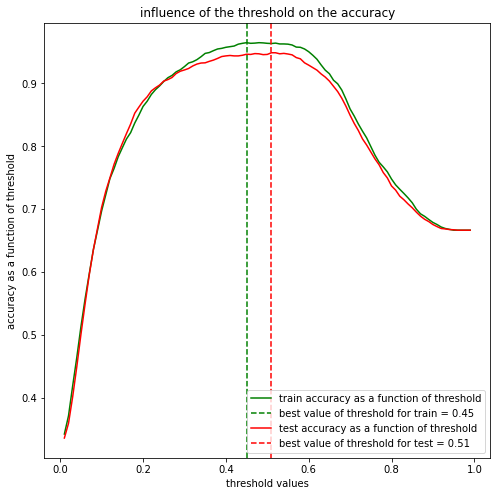

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_easy,y_test_easy,pred_train, y_train2)

train and hard set

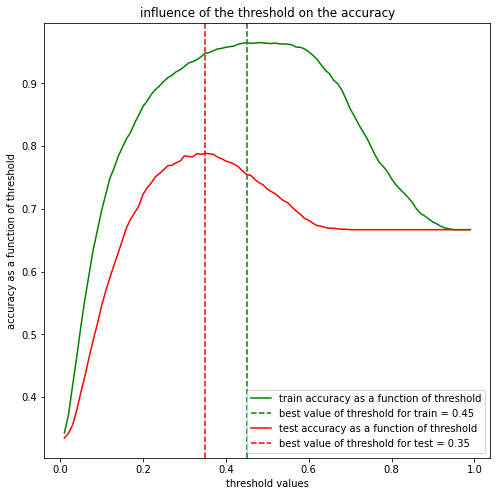

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test_hard,y_test_hard,pred_train, y_train2)

train and medium set

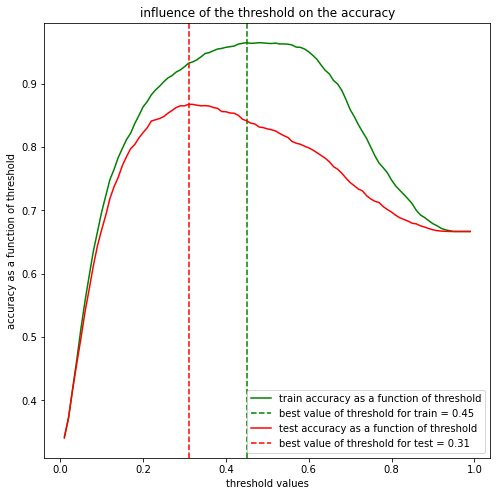

In [ ]:
best_train_threshold,best_test_threshold = threshold_plot2(pred_test,y_test,pred_train, y_train2)

## Comparison between the loss of the contrastive model and the binary cross entropy Model

It is important to mention that the contrastive loss starts to converge faster than the binary cross entropy loss. But we can't compare between the losses because they are completely different

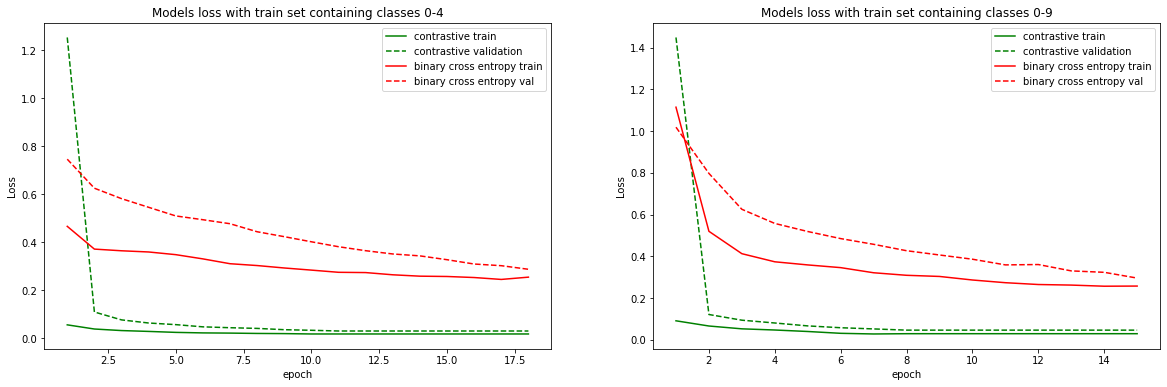

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
loss_comparison_plot(history,history_3)
plt.title('Models loss with train set containing classes 0-4')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.subplot(122)
loss_comparison_plot(history2,history_4)
plt.title('Models loss with train set containing classes 0-9')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

## III- Triplet Loss : 

### III-1- Random choice of triplets , train only on classes 0 to 4 :

### III-1-1 Prepare the data

In [ ]:
x = np.concatenate([all_train[0],all_train[1],all_train[2],all_train[3],all_train[4]],axis = 0)
y = np.array([0]*all_train[0].shape[0]+[1]*all_train[1].shape[0]+[2]*all_train[2].shape[0]+[3]*all_train[3].shape[0]+[4]*all_train[4].shape[0])

In [ ]:
x,y = shuffle(x, y, random_state=0)

In [ ]:
X_train, _ = generate_triplet(x,y, ap_pairs=150, an_pairs=200,testsize=0)
_, X_test = generate_triplet(test_images,test_labels, ap_pairs=30, an_pairs=30,testsize=1)

In [ ]:
X_train.shape, X_test.shape

((150000, 3, 784), (9000, 3, 784))

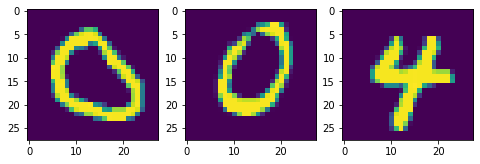

In [ ]:
fig=plt.figure(figsize=(8, 8))
index = random.randint(0,2400)
fig.add_subplot(1,3,1)
plt.imshow(X_train[index,0,:].reshape(28,28))
fig.add_subplot(1,3,2)
plt.imshow(X_train[index,1,:].reshape(28,28))
fig.add_subplot(1,3,3)
plt.imshow(X_train[index,2,:].reshape(28,28))

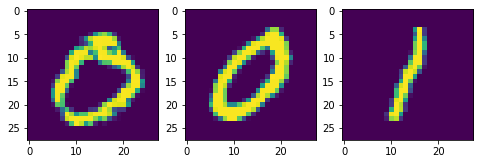

In [ ]:
fig=plt.figure(figsize=(8, 8))
index = random.randint(0,2400)
fig.add_subplot(1,3,1)
plt.imshow(X_test[index,0,:].reshape(28,28))
fig.add_subplot(1,3,2)
plt.imshow(X_test[index,1,:].reshape(28,28))
fig.add_subplot(1,3,3)
plt.imshow(X_test[index,2,:].reshape(28,28))

#### III-1- 2- Build the model and train It 

In [ ]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items

Shared_DNN = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model_triplet = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet.compile(loss=triplet_loss, optimizer=adam_optim)

In [ ]:
model_triplet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 10)           1199882     anchor_input[0][0]               
                                                                 positive_input[0][0]  

In [ ]:
Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

history_random = model_triplet.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=35, epochs=20, callbacks = [es])

Epoch 1/20
y_pred.shape =  Tensor("functional_9/merged_layer/concat:0", shape=(None, 30), dtype=float32)
y_pred.shape =  Tensor("functional_9/merged_layer/concat:0", shape=(None, 30), dtype=float32)
4286/4286 [==============================] - 31s 7ms/step - loss: 0.5076 - val_loss: 0.2487
Epoch 2/20
4286/4286 [==============================] - 30s 7ms/step - loss: 0.1046 - val_loss: 0.1433
Epoch 3/20
4286/4286 [==============================] - 30s 7ms/step - loss: 0.0409 - val_loss: 0.0961
Epoch 4/20
4286/4286 [==============================] - 31s 7ms/step - loss: 0.0213 - val_loss: 0.0725
Epoch 5/20
4286/4286 [==============================] - 31s 7ms/step - loss: 0.0113 - val_loss: 0.0574
Epoch 6/20
4286/4286 [==============================] - 31s 7ms/step - loss: 0.0079 - val_loss: 0.0463
Epoch 7/20
4286/4286 [==============================] - 31s 7ms/step - loss: 0.0045 - val_loss: 0.0405
Epoch 8/20
4286/4286 [==============================] - 31s 7ms/step - loss: 0.0032 - val_l

### III-1-3- Impact of the threshold on the accuracy

In [ ]:
x_test.shape

(3000, 28, 28, 1, 2)

In [ ]:
encod1 = Shared_DNN.predict(x_test.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN.predict(x_test.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

In [ ]:
distances = np.array(euclidean_distance((encod1, encod2)))

In [ ]:
acc = compute_accuracy(distances, y_test,0.5)
print(acc)

0.7126666666666667


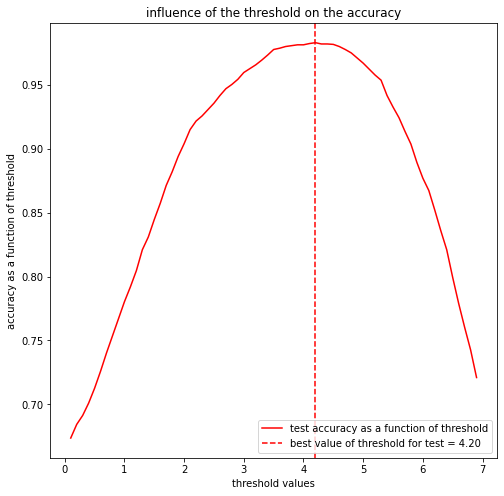

In [ ]:
threshold_list = [i*0.1 for i in range (1,70)]
test_acc_list = [compute_accuracy(distances, y_test,threshold) for threshold in threshold_list]
test_index_max = np.argmax(np.array(test_acc_list))

plt.figure(figsize = (8,8))
plt.plot(threshold_list,test_acc_list,label='test accuracy as a function of threshold', c='red')
plt.axvline(x=threshold_list[test_index_max], color='red',linestyle='--',label='best value of threshold for test = {:.2f}'.format(threshold_list[test_index_max]))
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

Let's show the training and test examples in the latent space using T-SNE

In [ ]:
tsne = TSNE()
X_train_trm = Shared_DNN.predict(x_train_flat[:512].reshape(-1,28,28,1))
X_test_trm = Shared_DNN.predict(x_test_flat[:512].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

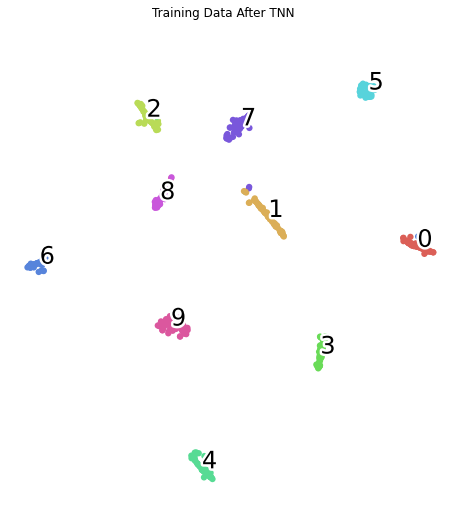

In [ ]:
scatter(train_tsne_embeds, train_labels[:512], "Training Data After TNN")

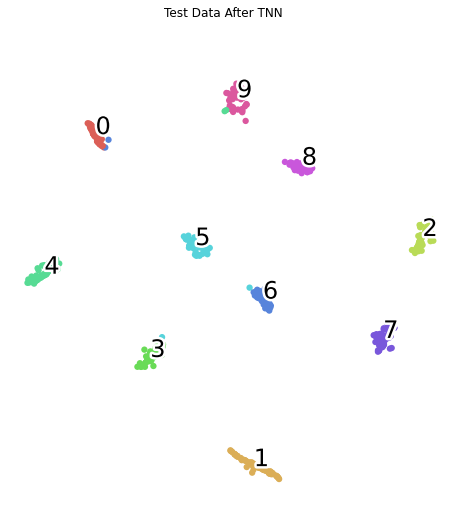

In [ ]:
scatter(eval_tsne_embeds, test_labels[:512], "Test Data After TNN")

### VI- Comparison of all the three models

In [65]:
number_of_processes = 10
size_of_encoding_triplet = 10
size_of_encoding_contrastive = 10
size_of_encoding_binary = 10
# 'easy' if you want to pull a test image between classes 0-4
# 'medium' if you want to pull a test image between classes 0-9
# 'hard' if you want to pull a test image between classes 5-9
acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes , 'triplet',size_of_encoding_triplet,'medium')
acc2 = n_way_one_shotlearning (base_network_contrastive, all_train,all_test, number_of_processes , 'contrastive',size_of_encoding_contrastive,'medium')
acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 'binary_crossentropy',size_of_encoding_binary,'medium')

In [66]:
acc1[1], acc2[1], acc3[1]

(1.0, 0.8, 0.9)

a- Comparison of the accuracy on the medium dataset

In [ ]:
nb = np.arange(10,2000,20)
acc_triplet = []
acc_binary = []
acc_contrastive = []
number_of_processes = 20
for number_of_processes in nb:
  acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'medium')
  acc2 = n_way_one_shotlearning (base_network_contrastive, all_train,all_test, number_of_processes ,
                                 'contrastive',size_of_encoding_contrastive,'medium')
  acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 
                                 'binary_crossentropy',size_of_encoding_binary,'medium')
  acc_triplet.append(acc1[1])
  acc_contrastive.append(acc2[1])
  acc_binary.append(acc3[1])

In [ ]:
np.mean(acc_triplet), np.mean(acc_contrastive), np.mean(acc_binary)

(0.9710000000000001, 0.8634999999999999, 0.7735000000000001)

Showing the results directly is bad idea since we have alot of iterations. We considered smoothening the curves of the accuracy in order to give a better overview of the performance of each model. 

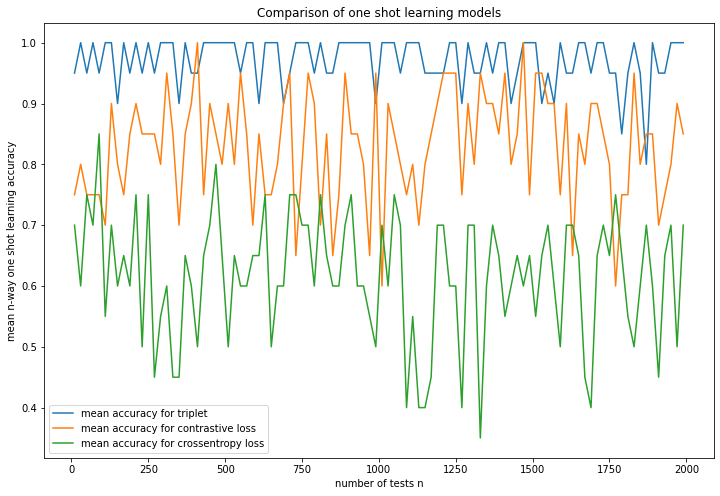

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(nb,acc_triplet,label='mean accuracy for triplet')
plt.plot(nb,acc_contrastive,label='mean accuracy for contrastive loss')
plt.plot(nb,acc_binary,label='mean accuracy for crossentropy loss')
plt.xlabel('number of tests n')
plt.ylabel('mean n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()

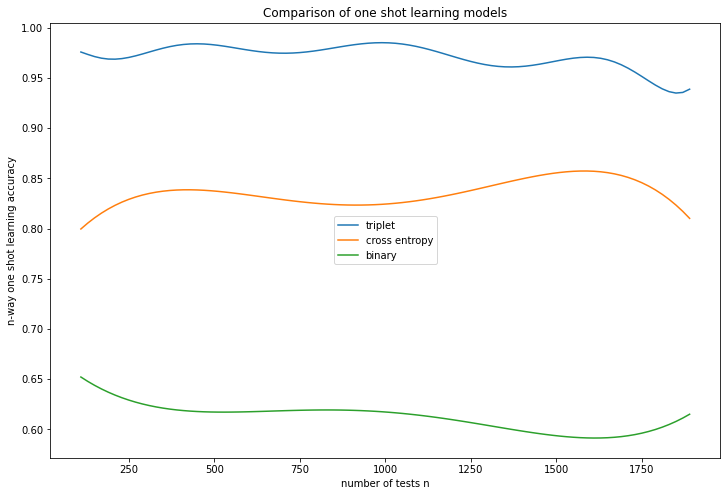

In [ ]:

plt.figure(figsize=(12,8))
poly = np.polyfit(nb,acc_triplet,10)
poly_y1 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_contrastive,4)
poly_y2 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_binary,4)
poly_y3 = np.poly1d(poly)(nb)
plt.plot(nb[5:95],poly_y1[5:95],label='triplet')
plt.plot(nb[5:95],poly_y2[5:95],label='cross entropy')
plt.plot(nb[5:95],poly_y3[5:95],label='binary')
plt.xlabel('number of tests n')
plt.ylabel('n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()

b- Comparison of the accuracy on the hard dataset

In [ ]:
nb = np.arange(20,2000,20)
acc_triplet = []
acc_binary = []
acc_contrastive = []
for number_of_processes in nb:
  if (200 % i ==0): print(i)
  acc1 = n_way_one_shotlearning (Shared_DNN, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'hard')
  acc2 = n_way_one_shotlearning (base_network_contrastive, all_train,all_test, number_of_processes ,
                                 'contrastive',size_of_encoding_contrastive,'hard')
  acc3 = n_way_one_shotlearning (base_network_binary, all_train,all_test, number_of_processes , 
                                 'binary_crossentropy',size_of_encoding_binary,'hard')
  acc_triplet.append(acc1[1])
  acc_contrastive.append(acc2[1])
  acc_binary.append(acc3[1])

In [70]:
np.mean(acc_triplet), np.mean(acc_contrastive), np.mean(acc_binary)

(0.9585858585858587, 0.7313131313131314, 0.6131313131313132)

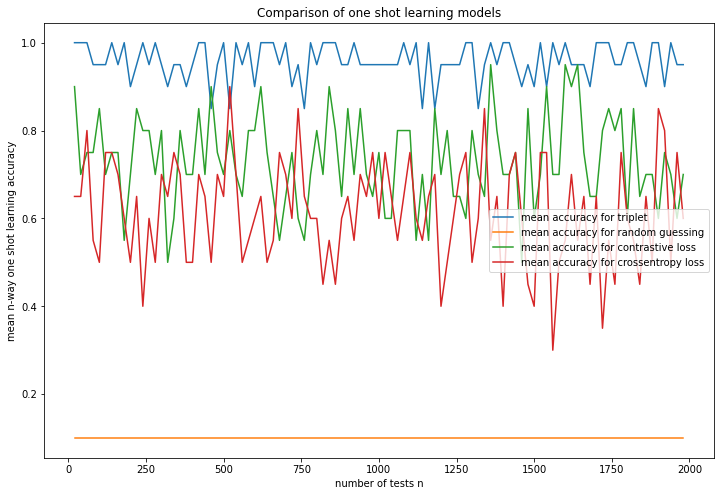

In [71]:
plt.figure(figsize = (12,8))
plt.plot(nb,acc_triplet,label='mean accuracy for triplet')
plt.plot(nb,[0.1]*len(nb), label = 'mean accuracy for random guessing')
plt.plot(nb,acc_contrastive,label='mean accuracy for contrastive loss')
plt.plot(nb,acc_binary,label='mean accuracy for crossentropy loss')
plt.xlabel('number of tests n')
plt.ylabel('mean n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()

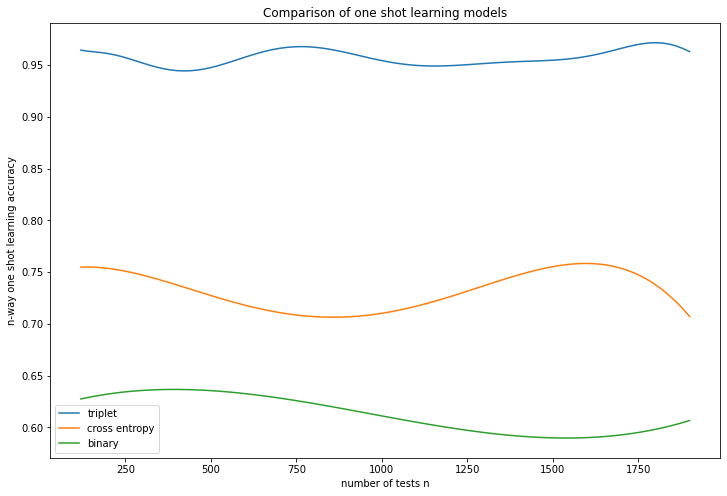

In [73]:
plt.figure(figsize=(12,8))
poly = np.polyfit(nb,acc_triplet,10)
poly_y1 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_contrastive,4)
poly_y2 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_binary,3)
poly_y3 = np.poly1d(poly)(nb)
plt.plot(nb[5:95],poly_y1[5:95],label='triplet')
plt.plot(nb[5:95],poly_y2[5:95],label='cross entropy')
plt.plot(nb[5:95],poly_y3[5:95],label='binary')
plt.xlabel('number of tests n')
plt.ylabel('n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()

Illustration of one pass of n way one shot learning (We can notice that the minimum distance between the test image and the representative image of each class)



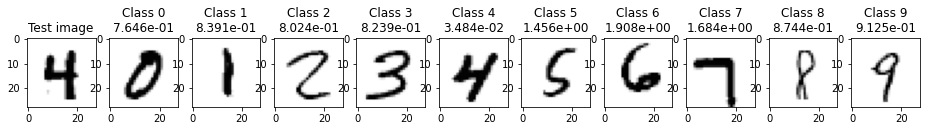

In [ ]:
one_way_one_shotlearning (base_network_contrastive, all_train, all_test , 'contrastive',size_of_encoding_contrastive)

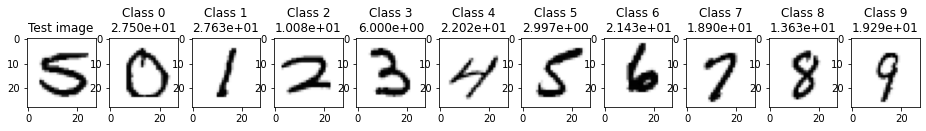

In [ ]:
one_way_one_shotlearning (base_network_binary, all_train, all_test , 'contrastive',size_of_encoding_contrastive)

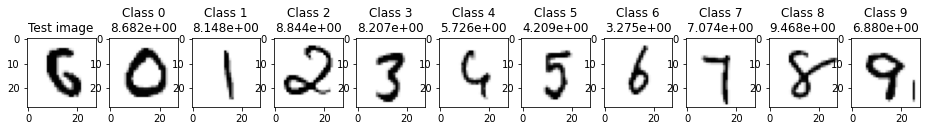

In [ ]:
one_way_one_shotlearning (Shared_DNN, all_train, all_test , 'contrastive',size_of_encoding_contrastive)

# Impact of the triplet choice on the siamese network training speed :

find easy triplets, hard triplets, and semi hard triplets

In [ ]:
easy_triplet_train,hard_triplet_train,semihard_triplet_train,random_triplet_train=triplet_type(X_train,0.01)


In [ ]:
 X_train.shape[0], easy_triplet_train.shape[0], hard_triplet_train.shape[0], semihard_triplet_train.shape[0]

(150000, 117661, 32071, 268)

choose train sets : random , easy and hard of same size 5000

In [ ]:
indexes = np.random.randint(X_train.shape[0], size=5000)
X_train2 = X_train[indexes,:]

In [ ]:
indexes = np.random.randint(easy_triplet_train.shape[0], size=5000)
easy_triplet_train = easy_triplet_train[indexes,:]

In [ ]:
indexes = np.random.randint(hard_triplet_train.shape[0], size=5000)
hard_triplet_train = hard_triplet_train[indexes,:]

a- train only on random triplets

In [ ]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items

Shared_DNN_random = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN_random.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN_random(anchor_input)
encoded_positive = Shared_DNN_random(positive_input)
encoded_negative = Shared_DNN_random(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')


In [ ]:
n_epochs = 20
Anchor_random = X_train2[:,0,:].reshape(-1,28,28,1)
Positive_random = X_train2[:,1,:].reshape(-1,28,28,1)
Negative_random = X_train2[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)
batch_size = 128

Y_dummy = np.empty((Anchor_random.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

model_triplet_random= Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet_random.compile(loss=triplet_loss, optimizer=adam_optim)
history_random = model_triplet_random.fit([Anchor_random,Positive_random,Negative_random],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=batch_size, epochs=n_epochs)

Epoch 1/20
y_pred.shape =  Tensor("functional_61/merged_layer/concat:0", shape=(None, 30), dtype=float32)
y_pred.shape =  Tensor("functional_61/merged_layer/concat:0", shape=(None, 30), dtype=float32)
40/40 [==============================] - 1s 23ms/step - loss: 1.8106 - val_loss: 0.5895
Epoch 2/20
40/40 [==============================] - 1s 19ms/step - loss: 1.4943 - val_loss: 0.5810
Epoch 3/20
40/40 [==============================] - 1s 18ms/step - loss: 1.5080 - val_loss: 0.5748
Epoch 4/20
40/40 [==============================] - 1s 18ms/step - loss: 1.4390 - val_loss: 0.5708
Epoch 5/20
40/40 [==============================] - 1s 18ms/step - loss: 1.2591 - val_loss: 0.5688
Epoch 6/20
40/40 [==============================] - 1s 18ms/step - loss: 1.1203 - val_loss: 0.5661
Epoch 7/20
40/40 [==============================] - 1s 18ms/step - loss: 0.9138 - val_loss: 0.5647
Epoch 8/20
40/40 [==============================] - 1s 18ms/step - loss: 1.1045 - val_loss: 0.5578
Epoch 9/20
40/40 [

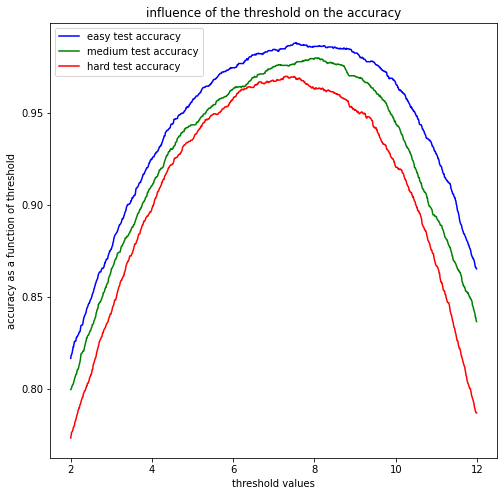

In [ ]:
distances = []

encod1 = Shared_DNN_random.predict(x_test_easy.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_random.predict(x_test_easy.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_random.predict(x_test.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_random.predict(x_test.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_random.predict(x_test_hard.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_random.predict(x_test_hard.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

acc_list = []
y = [y_train, y_test_easy,y_test,y_test_hard]
threshold_list = [i*0.01 for i in range (200,1200)]
for i in range(len(distances)):
  acc_list.append([compute_accuracy(distances[i], y[i],threshold) for threshold in threshold_list])

plt.figure(figsize = (8,8))
plt.plot(threshold_list,acc_list[0],label='easy test accuracy', c='blue')
plt.plot(threshold_list,acc_list[1],label='medium test accuracy', c='green')
plt.plot(threshold_list,acc_list[2],label='hard test accuracy', c='red')
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

b- Train the model using only hard triplets

In [ ]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items

Shared_DNN_hard = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN_hard.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN_hard(anchor_input)
encoded_positive = Shared_DNN_hard(positive_input)
encoded_negative = Shared_DNN_hard(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')


In [ ]:
Anchor_hard = hard_triplet_train[:,0,:].reshape(-1,28,28,1)
Positive_hard = hard_triplet_train[:,1,:].reshape(-1,28,28,1)
Negative_hard = hard_triplet_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor_hard.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

In [ ]:
model_triplet_hard = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet_hard.compile(loss=triplet_loss, optimizer=adam_optim)
history_hard = model_triplet_hard.fit([Anchor_hard,Positive_hard,Negative_hard],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=batch_size, epochs=n_epochs)

Epoch 1/20
y_pred.shape =  Tensor("functional_63/merged_layer/concat:0", shape=(None, 30), dtype=float32)
y_pred.shape =  Tensor("functional_63/merged_layer/concat:0", shape=(None, 30), dtype=float32)
40/40 [==============================] - 1s 22ms/step - loss: 3.2742 - val_loss: 0.5977
Epoch 2/20
40/40 [==============================] - 1s 18ms/step - loss: 2.9223 - val_loss: 0.5908
Epoch 3/20
40/40 [==============================] - 1s 18ms/step - loss: 2.7498 - val_loss: 0.5867
Epoch 4/20
40/40 [==============================] - 1s 18ms/step - loss: 1.9789 - val_loss: 0.5843
Epoch 5/20
40/40 [==============================] - 1s 18ms/step - loss: 2.3368 - val_loss: 0.5857
Epoch 6/20
40/40 [==============================] - 1s 18ms/step - loss: 1.8842 - val_loss: 0.5837
Epoch 7/20
40/40 [==============================] - 1s 18ms/step - loss: 1.6741 - val_loss: 0.5794
Epoch 8/20
40/40 [==============================] - 1s 18ms/step - loss: 1.7664 - val_loss: 0.5744
Epoch 9/20
40/40 [

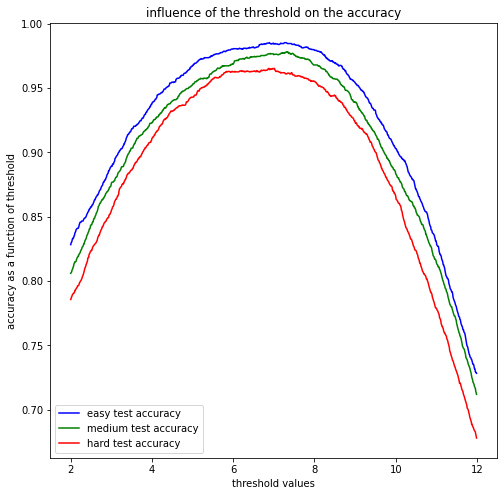

In [ ]:
distances = []

encod1 = Shared_DNN_hard.predict(x_test_easy.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_hard.predict(x_test_easy.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_hard.predict(x_test.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_hard.predict(x_test.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_hard.predict(x_test_hard.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_hard.predict(x_test_hard.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))
acc_list = []
y = [y_train, y_test_easy,y_test,y_test_hard]
threshold_list = [i*0.01 for i in range (200,1200)]
for i in range(len(distances)):
  acc_list.append([compute_accuracy(distances[i], y[i],threshold) for threshold in threshold_list])

plt.figure(figsize = (8,8))
plt.plot(threshold_list,acc_list[0],label='easy test accuracy', c='blue')
plt.plot(threshold_list,acc_list[1],label='medium test accuracy', c='green')
plt.plot(threshold_list,acc_list[2],label='hard test accuracy', c='red')
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

c- train the model using only easy triplets 

In [ ]:
adam_optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999)
anchor_input = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items

Shared_DNN_easy = tf.keras.models.clone_model(tmodel_modified)
Shared_DNN_easy.set_weights(tmodel_modified.get_weights()) 

encoded_anchor = Shared_DNN_easy(anchor_input)
encoded_positive = Shared_DNN_easy(positive_input)
encoded_negative = Shared_DNN_easy(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')


In [ ]:
Anchor_easy = easy_triplet_train[:,0,:].reshape(-1,28,28,1)
Positive_easy = easy_triplet_train[:,1,:].reshape(-1,28,28,1)
Negative_easy = easy_triplet_train[:,2,:].reshape(-1,28,28,1)
Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)

Y_dummy = np.empty((Anchor_easy.shape[0],300)) ## Vector that is not used in training
Y_dummy2 = np.empty((Anchor_test.shape[0],1)) ## Vector that is not used in training

model_triplet_easy = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model_triplet_easy.compile(loss=triplet_loss, optimizer=adam_optim)
history_easy= model_triplet_easy.fit([Anchor_easy,Positive_easy,Negative_easy],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=batch_size, epochs=n_epochs)

Epoch 1/20
y_pred.shape =  Tensor("functional_65/merged_layer/concat:0", shape=(None, 30), dtype=float32)
y_pred.shape =  Tensor("functional_65/merged_layer/concat:0", shape=(None, 30), dtype=float32)
40/40 [==============================] - 1s 22ms/step - loss: 1.1186 - val_loss: 0.5889
Epoch 2/20
40/40 [==============================] - 1s 18ms/step - loss: 1.0727 - val_loss: 0.5849
Epoch 3/20
40/40 [==============================] - 1s 18ms/step - loss: 0.8588 - val_loss: 0.5815
Epoch 4/20
40/40 [==============================] - 1s 18ms/step - loss: 0.9448 - val_loss: 0.5753
Epoch 5/20
40/40 [==============================] - 1s 18ms/step - loss: 0.9573 - val_loss: 0.5653
Epoch 6/20
40/40 [==============================] - 1s 18ms/step - loss: 0.7794 - val_loss: 0.5589
Epoch 7/20
40/40 [==============================] - 1s 18ms/step - loss: 0.8934 - val_loss: 0.5557
Epoch 8/20
40/40 [==============================] - 1s 18ms/step - loss: 0.9937 - val_loss: 0.5462
Epoch 9/20
40/40 [

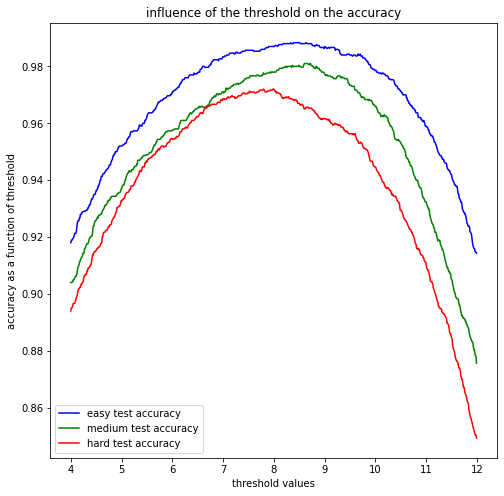

In [ ]:
distances = []

encod1 = Shared_DNN_easy.predict(x_test_easy.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_easy.predict(x_test_easy.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_easy.predict(x_test.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_easy.predict(x_test.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

encod1 = Shared_DNN_easy.predict(x_test_hard.reshape(-1,28,28,2)[:,:,:,0].reshape(-1,28,28,1))
encod2 = Shared_DNN_easy.predict(x_test_hard.reshape(-1,28,28,2)[:,:,:,1].reshape(-1,28,28,1))

distances.append(np.array(euclidean_distance((encod1, encod2))))

acc_list = []
y = [y_train, y_test_easy,y_test,y_test_hard]
threshold_list = [i*0.01 for i in range (400,1200)]
for i in range(len(distances)):
  acc_list.append([compute_accuracy(distances[i], y[i],threshold) for threshold in threshold_list])

plt.figure(figsize = (8,8))
plt.plot(threshold_list,acc_list[0],label='easy test accuracy', c='blue')
plt.plot(threshold_list,acc_list[1],label='medium test accuracy', c='green')
plt.plot(threshold_list,acc_list[2],label='hard test accuracy', c='red')
plt.xlabel('threshold values')
plt.ylabel('accuracy as a function of threshold')
plt.title('influence of the threshold on the accuracy')
plt.legend()
plt.show()

d- compare the three approaches (random, hard and easy)

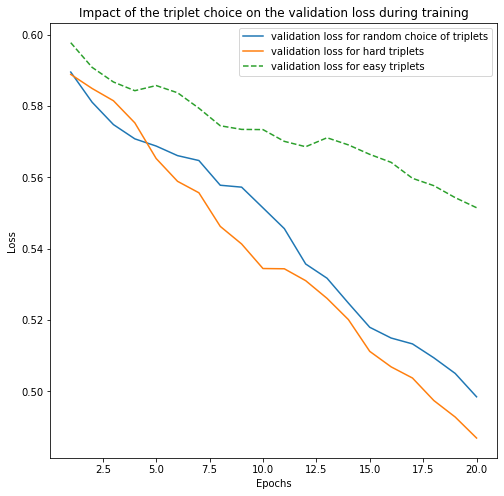

In [ ]:
plt.figure(figsize=(8, 8))
history_dict1 = history_random.history
history_dict2 = history_hard.history
history_dict3 = history_easy.history

loss_values1 = history_dict1['val_loss']
loss_values2 = history_dict2['val_loss']
loss_values3 = history_dict3['val_loss']

epochs = range(1, len(loss_values1) + 1)
plt.plot(epochs, loss_values1, label='validation loss for random choice of triplets')
plt.plot(epochs, loss_values2, label='validation loss for hard triplets')
plt.plot(epochs, loss_values3, label='validation loss for easy triplets', linestyle='--')
plt.title('Impact of the triplet choice on the validation loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

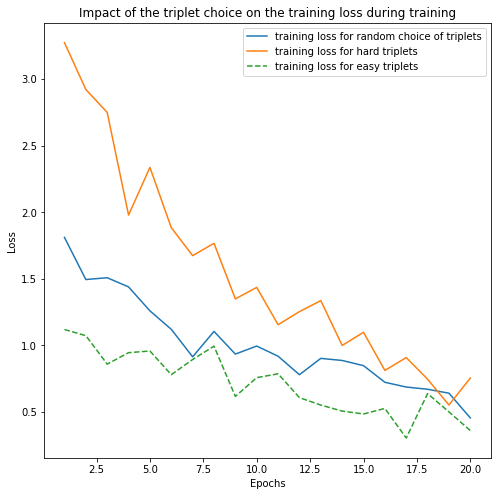

In [ ]:
plt.figure(figsize=(8, 8))
history_dict1 = history_random.history
history_dict2 = history_hard.history
history_dict3 = history_easy.history

loss_values1 = history_dict1['loss']
loss_values2 = history_dict2['loss']
loss_values3 = history_dict3['loss']

epochs = range(1, len(loss_values1) + 1)
plt.plot(epochs, loss_values1, label='training loss for random choice of triplets')
plt.plot(epochs, loss_values2, label='training loss for hard triplets')
plt.plot(epochs, loss_values3, label='training loss for easy triplets', linestyle='--')
plt.title('Impact of the triplet choice on the training loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## STPOOOOOOOOOOOOOOOOOOOOOOP

In [ ]:
number_of_processes = 10
size_of_encoding_triplet = 10
size_of_encoding_contrastive = 10
size_of_encoding_binary = 10

nb = np.arange(10,2000,20)
acc_triplet_random = []
acc_triplet_hard = []
acc_triplet_easy = []
for number_of_processes in nb:
  acc1 = n_way_one_shotlearning (Shared_DNN_random, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'hard')
  acc2 = n_way_one_shotlearning (Shared_DNN_hard, all_train,all_test, number_of_processes ,
                                 'triplet',size_of_encoding_triplet,'hard')
  acc3 = n_way_one_shotlearning (Shared_DNN_easy, all_train,all_test, number_of_processes , 
                                 'triplet',size_of_encoding_triplet,'hard')
  acc_triplet_random.append(acc1[1])
  acc_triplet_hard.append(acc2[1])
  acc_triplet_easy.append(acc3[1])

In [ ]:
np.mean(acc_triplet_random), np.mean(acc_triplet_hard), np.mean(acc_triplet_easy)

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(nb,acc_triplet_random,label='mean accuracy for random triplet')
plt.plot(nb,acc_triplet_hard,label='mean accuracy for hard triplet')
plt.plot(nb,acc_triplet_easy,label='mean accuracy for easy triplet')
plt.xlabel('number of tests n')
plt.ylabel('mean n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
poly = np.polyfit(nb,acc_triplet_random,5)
poly_y1 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_triplet_hard,5)
poly_y2 = np.poly1d(poly)(nb)
poly = np.polyfit(nb,acc_triplet_easy,5)
poly_y3 = np.poly1d(poly)(nb)
plt.plot(nb,poly_y1,label='random triplet')
plt.plot(nb,poly_y2,label='hard triplet')
plt.plot(nb,poly_y3,label='easy triplet')
plt.xlabel('number of tests n')
plt.ylabel('n-way one shot learning accuracy')
plt.title('Comparison of one shot learning models')
plt.legend()
plt.ylim((0.5,1.05))
plt.show()